# Run this on Colab

## Do not use circle tool in lableme, just use linstripe or polygon to do the annotation.


# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# torch version updaed to 1.7.0; 11/24/2020
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.7.0")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Prepare the dataset

In [ ]:
# download, decompress the data, failed as the .zip is corrupted somehow. 
#!wget https://github.com/neclipse/Metal_defects_detection/blob/Pilot_run/pilot_dataset_new.zip
#!unzip pilot_dataset_new.zip > /dev/null

--2020-11-25 01:47:03--  https://github.com/neclipse/Metal_defects_detection/blob/Pilot_run/pilot_dataset_new.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pilot_dataset_new.zip’

pilot_dataset_new.z     [ <=>                ]  90.18K  --.-KB/s    in 0.009s  

2020-11-25 01:47:03 (9.40 MB/s) - ‘pilot_dataset_new.zip’ saved [92348]

  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of pilot_dataset_new.zip or
        pilot_dataset_new.zip.zip, and cannot find pilot_dataset_new.zip.ZIP, period.


In [ ]:
# try to use google drive instead
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/pilot_dataset.zip

Archive:  /content/drive/MyDrive/pilot_dataset.zip
   creating: pilot_dataset/
   creating: pilot_dataset/train/
   creating: pilot_dataset/validate/
  inflating: pilot_dataset/train/1100_016 cropped.json  
  inflating: pilot_dataset/train/1100_016 cropped.png  
  inflating: pilot_dataset/train/1100_028 cropped.json  
  inflating: pilot_dataset/train/1100_028 cropped.png  
  inflating: pilot_dataset/validate/full_sem_sample.jpg  
  inflating: pilot_dataset/validate/full_sem_sample.json  


In [ ]:
# directly move file/directory between googledrive and colab
# To colab
#!cp -r /content/drive/MyDrive/pilot_dataset /content
# To googledrive 
#!cp -r pilot_dataset drive/MyDrive/

In [ ]:
# convert the dataset into coco format using labelme2coco
#!pip install labelme2coco

# import package
import labelme2coco
labelme2coco.convert("pilot_dataset/train", "pilot_dataset/train/annotation_train.json")
labelme2coco.convert("pilot_dataset/validate", "pilot_dataset/validate/annotation_validate.json")


Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is already converted to COCO format so that we can directly register it using [register_coco_instances](https://github.com/facebookresearch/detectron2/blob/786875e03a3d88a06e4b3ff9cfd5120b0f04e14c/detectron2/data/datasets/coco.py#L449).

### Important to note that the lableme2coco and register_coco_instances will repeatedly add the root directory to the file name, leading to an error. 
Therefore, try to leave the root directory empty in register_coco_instances in the next cell.


In [ ]:
from detectron2.data.datasets import register_coco_instances
# args: name(str), metadata (dict): default empty, json_file_path (str), image_root (str or path like): root directory for images  
register_coco_instances("my_dataset_t", {}, "pilot_dataset/train/annotation_train.json", "")
register_coco_instances("my_dataset_v", {}, "pilot_dataset/validate/annotation_validate.json", "")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

### Important to note that the circle annotations are not translated by lableme2coco. Do not use it for further projects.

[11/25 04:00:21 d2.data.datasets.coco]: Loaded 2 images in COCO format from annotation_train.json
WARNING [11/25 04:00:21 d2.data.datasets.coco]: Filtered out 51 instances without valid segmentation. There might be issues in your dataset generation process. A valid polygon should be a list[float] with even length >= 6.
pilot_dataset/train/1100_028 cropped.png


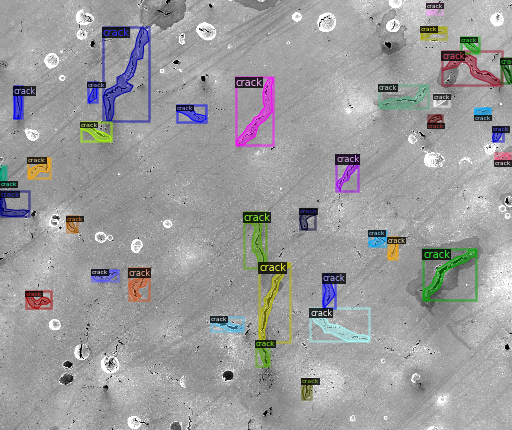

In [ ]:
dataset_dict=DatasetCatalog.get("my_dataset_t")
mymetadata=MetadataCatalog.get("my_dataset_t")
#dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dict, 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mymetadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [1]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

ModuleNotFoundError: ignored

In [6]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Launching TensorBoard...

KeyboardInterrupt: ignored

# Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [2]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

ModuleNotFoundError: ignored

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [5]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

ModuleNotFoundError: ignored

# Other types of builtin models

In [3]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

NameError: ignored

In [4]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

NameError: ignored